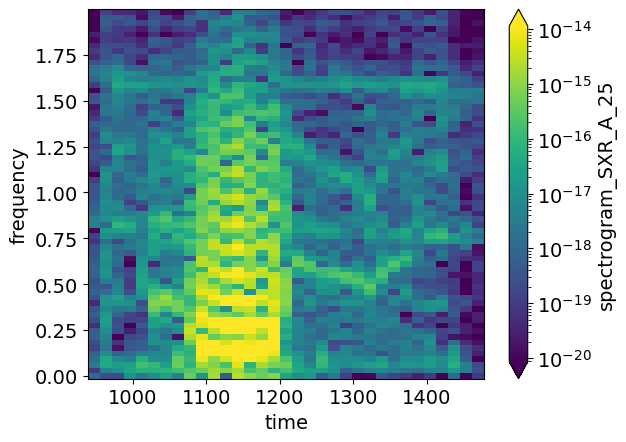

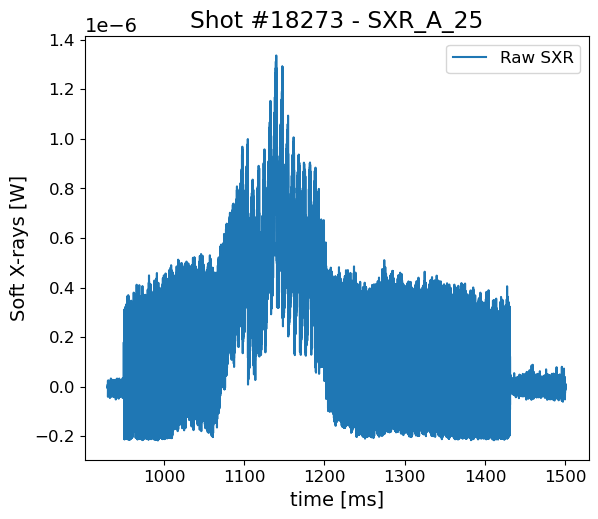

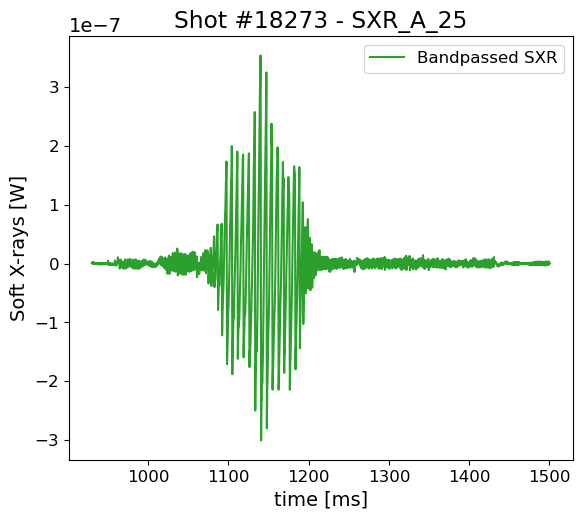

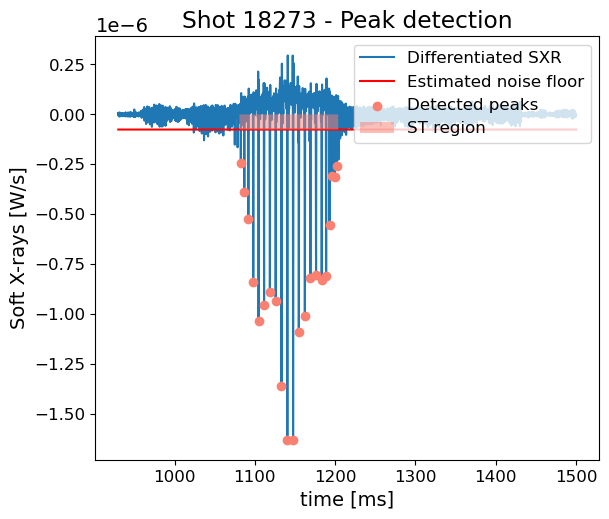

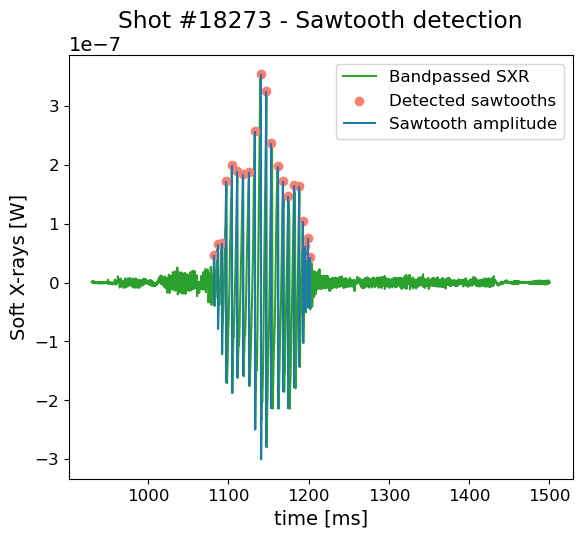

In [1]:
# Author: Magne Lauritzen, mag.lauritzen@gmail.com
# -- use this line at the beginning of your notebook to turn on interactive plots
%matplotlib notebook

# Imports
from statsmodels.nonparametric.smoothers_lowess import lowess
import sys
import matplotlib.pyplot as plt  # plotting library
from matplotlib import colors
import numpy as np  # work with numeric arrays without labeled axes
import xarray as xr  # work with arrays with labeled axes
import xrscipy.signal as dsp  # xarray signal filtering etc.
import scipy as sps
from cdb_extras import xarray_support as cdbxr  # access to COMPASS Database (CDB)
import pickle # to load data
from pathlib import Path # to easily work with different files
from progressbar import ProgressBar
plt.rcParams.update({'font.size': 14})

%run ./functions.ipynb

In [6]:
# Define a dataclass to hold the pedestal fit results
@dataclass
class PedestalParams:
    shot_number: int
    
    ne_height: np.ndarray
    ne_height_err: np.ndarray
    ne_grad: np.ndarray
    ne_grad_err: np.ndarray
    ne_width: np.ndarray
    ne_width_err: np.ndarray
    ne_time: np.ndarray
    ne_ELM_phase: np.ndarray
    ne_ELM_time: np.ndarray
    ne_ST_phase: np.ndarray
    ne_ST_time: np.ndarray
        
    Te_height: np.ndarray
    Te_height_err: np.ndarray
    Te_grad: np.ndarray
    Te_grad_err: np.ndarray
    Te_width: np.ndarray
    Te_width_err: np.ndarray
    Te_time: np.ndarray
    Te_ELM_phase: np.ndarray
    Te_ELM_time: np.ndarray
    Te_ST_phase: np.ndarray
    Te_ST_time: np.ndarray
        
    pe_height: np.ndarray
    pe_height_err: np.ndarray
    pe_grad: np.ndarray
    pe_grad_err: np.ndarray
    pe_width: np.ndarray
    pe_width_err: np.ndarray
    pe_time: np.ndarray
    pe_ELM_phase: np.ndarray
    pe_ELM_time: np.ndarray
    pe_ST_phase: np.ndarray
    pe_ST_time: np.ndarray

In [7]:
def get_data(shot_nr):
    shot = cdbxr.Shot(shot_nr)  # dict-like accessor to all signals measured in a given shot

    # Obtain Thomson data
    try:
        ne = shot(name="ne", variant="stray_corrected")
        ne_err = shot(name="ne_err", variant="stray_corrected")
        Te = shot(name="Te", variant="stray_corrected")
        Te_err = shot(name="Te_err", variant="stray_corrected")
        print("Using stray corrected data")
        pe = Te * ne * 1.602 / 1E19
        pe_err = np.sqrt((ne_err/ne)**2 + (Te_err/Te)**2) * pe
        pe["units"] = 'Pa'
    except Exception as exc:
        ne = shot[f"ne/THOMSON:{shot_nr}"]
        ne_err = shot[f"ne_err/THOMSON:{shot_nr}"]
        Te = shot[f"Te/THOMSON:{shot_nr}"]
        Te_err = shot[f"Te_err/THOMSON:{shot_nr}"]
        pe = shot[f"pe/THOMSON:{shot_nr}"]
        pe_err = shot[f"pe_err/THOMSON:{shot_nr}"]
        print(f"NOT using stray corrected data. Reason: {exc}")

    psi_n = shot['TS_psi_n']
    

    
    # Define interpolated Z for fits
    psi_n_fit_coords = np.linspace(0, 1.15, 100)

    return ne, ne_err, Te, Te_err, pe, pe_err, psi_n, psi_n_fit_coords

In [8]:
def fix_data(thomson_data, thomson_error, psi_n_data, timestamp):
    data = thomson_data.sel(time = timestamp, method='nearest')
    error = thomson_error.sel(time = timestamp, method='nearest')
    p = psi_n_data.sel(time = timestamp, method='nearest')
    
    data = data.assign_coords(Z=('Z', p.values))
    data = data.rename(Z='psi_n')
    error = error.assign_coords(Z=('Z', p.values))
    error = error.rename(Z='psi_n')
    limited_error = np.clip(error.data, a_min=0, a_max = np.nanmax(data.data))
    
    return data, limited_error


Using stray corrected data
Using stray corrected data
Using stray corrected data
Using stray corrected data
Using stray corrected data
Using stray corrected data
Using stray corrected data
Using stray corrected data
Using stray corrected data


2023-11-03 14:10:45,807 - pyCDB       : ERROR    signal not found


Using stray corrected data
NOT using stray corrected data. Reason: signal not found
Using stray corrected data
Using stray corrected data
Using stray corrected data
Using stray corrected data
Using stray corrected data
Using stray corrected data
Using stray corrected data
Using stray corrected data
Using stray corrected data
Using stray corrected data
Using stray corrected data
Using stray corrected data
Using stray corrected data


2023-11-03 14:10:50,631 - pyCDB       : ERROR    signal not found


NOT using stray corrected data. Reason: signal not found
Using stray corrected data
Using stray corrected data
Using stray corrected data
pre-ELM ST phase: 0.51 +- 0.2
post-ELM ST phase: 0.48 +- 0.3


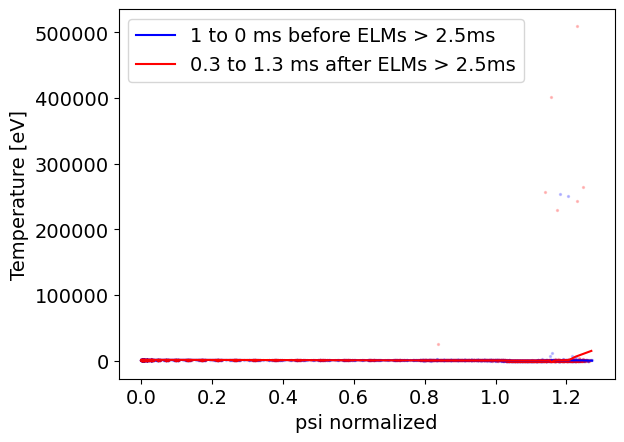

In [9]:
shot_list = [18252,18254,18255,18257,18260,18261,18263,18266,18267,18273,18274,18275,18276,18277]

plt.figure()
all_psi_n = np.empty(0)
all_y = np.empty(0)
all_ST_phases_pre_ELM = np.empty(0)
all_ST_phases_post_ELM = np.empty(0)

for shot_nr in shot_list:

    # Load thomson data
    ne, ne_err, Te, Te_err, pe, pe_err, psi_n, psi_n_fit_coords = get_data(shot_nr)

    with open(Path(f'./pedestal_data/{shot_nr}_ped.bin'), 'rb') as fp:
        pedestal_data: PedestalParams = pickle.load(fp)

    time = Te.coords['time']
    # Only keep the ones right before a big ELM
    ELM_phases, ELM_delays, ELM_duration = ELM_phase(shot_nr, time, relative_to_nearest=True)
    delay_mask = np.logical_and(ELM_delays > -1, ELM_delays < 0)
    duration_mask = ELM_duration > 2.5
    pre_ELM_thomson_timestamps = time[np.logical_and(delay_mask, duration_mask)]
    
    all_ST_phases_pre_ELM = np.concatenate((all_ST_phases_pre_ELM, 
                                             ST_time_and_phase(shot_nr, 
                                                               pre_ELM_thomson_timestamps, 
                                                               relative_to_nearest=False)[0]))
    
    # Plot them all
    for timestamp in pre_ELM_thomson_timestamps:
        data, limited_error = fix_data(Te, Te_err, psi_n, timestamp)
        plt.scatter(data.coords['psi_n'], data, ls='None', c='blue', alpha=0.2, s=2)#, yerr = limited_error)
        all_psi_n = np.concatenate((all_psi_n, data.coords['psi_n']))
        all_y = np.concatenate((all_y, data))

        
fit = lowess(all_y, all_psi_n, frac=0.1)
plt.plot(fit[:, 0], fit[:, 1], c='blue', label='1 to 0 ms before ELMs > 2.5ms')

      
all_psi_n = np.empty(0)
all_y = np.empty(0)
for shot_nr in shot_list:

    # Load thomson data
    ne, ne_err, Te, Te_err, pe, pe_err, psi_n, psi_n_fit_coords = get_data(shot_nr)

    with open(Path(f'./pedestal_data/{shot_nr}_ped.bin'), 'rb') as fp:
        pedestal_data: PedestalParams = pickle.load(fp)
    time = Te.coords['time']
    
    # Only keep the ones right after a big ELM
    ELM_phases, ELM_delays, ELM_duration = ELM_phase(shot_nr, time)
    delay_mask = np.logical_and(ELM_delays > 0.3, ELM_delays < 1.3)
    ELM_phases, ELM_delays, ELM_duration = ELM_phase(shot_nr, time-1.3)
    duration_mask = ELM_duration > 2.5
    post_ELM_thomson_timestamps = time[np.logical_and(delay_mask, duration_mask)]
    
    all_ST_phases_post_ELM = np.concatenate((all_ST_phases_post_ELM, 
                                             ST_time_and_phase(shot_nr, 
                                                               post_ELM_thomson_timestamps, 
                                                               relative_to_nearest=False)[0]))
    
    for timestamp in post_ELM_thomson_timestamps:
        data, limited_error = fix_data(Te, Te_err, psi_n, timestamp)
        plt.scatter(data.coords['psi_n'], data, ls='None', c='red', alpha=0.2, s=2)#, yerr = limited_error)
        all_psi_n = np.concatenate((all_psi_n, data.coords['psi_n']))
        all_y = np.concatenate((all_y, data))
        
fit = lowess(all_y, all_psi_n, frac=0.1)
plt.plot(fit[:, 0], fit[:, 1], c='red', label='0.3 to 1.3 ms after ELMs > 2.5ms')
plt.xlabel("psi normalized")
plt.ylabel('Temperature [eV]')
plt.legend()

print(f"pre-ELM ST phase: {np.nanmean(all_ST_phases_pre_ELM):.2f} +- {np.nanstd(all_ST_phases_pre_ELM):.1f}")
print(f"post-ELM ST phase: {np.nanmean(all_ST_phases_post_ELM):.2f} +- {np.nanstd(all_ST_phases_post_ELM):.1f}")


(array([3., 2., 1., 3., 2., 0., 0., 1., 1., 4.]),
 array([0.02490256, 0.1202252 , 0.21554784, 0.31087048, 0.40619312,
        0.50151577, 0.59683841, 0.69216105, 0.78748369, 0.88280634,
        0.97812898]),
 <BarContainer object of 10 artists>)

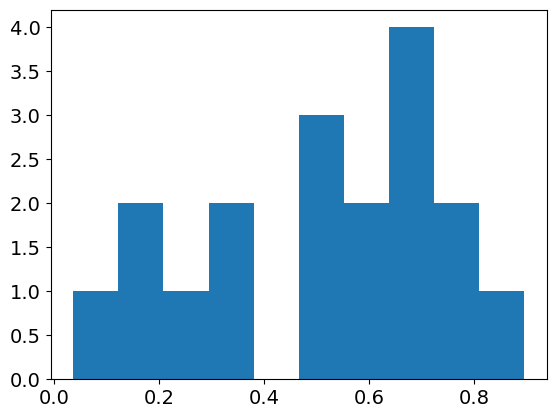

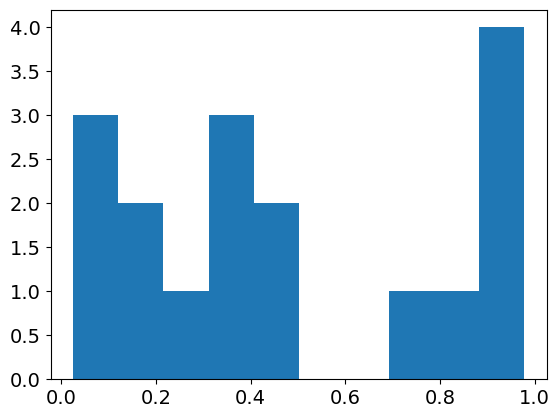

In [10]:
plt.figure()
plt.hist(all_ST_phases_pre_ELM)
plt.figure()
plt.hist(all_ST_phases_post_ELM)